In [24]:
import keras
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop

from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
import keras.backend.tensorflow_backend as KTF
K.clear_session()
config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   
session = tf.Session(config=config)
KTF.set_session(session)

In [25]:
(x_train,y_train),(x_test,y_test) = cifar100.load_data()

In [26]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


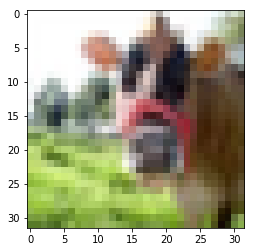

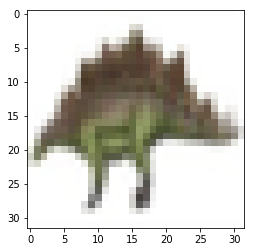

In [27]:
plt.imshow(x_train[0])
plt.show()
plt.imshow(x_train[1])
plt.show()

In [28]:
x_train = x_train / 255
x_test = x_test / 255
y_train = keras.utils.np_utils.to_categorical(y_train, 100)
y_test = keras.utils.np_utils.to_categorical(y_test, 100)

In [29]:
model = Sequential()

In [30]:
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

In [31]:
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [32]:
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

In [33]:
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('softmax'))

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 128)       147584    
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       295168    
__________

In [35]:
plot_model(model,to_file='model.png')

In [36]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

In [37]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [38]:
tensorboard = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                batch_size=32,
                write_graph=True,
                write_grads=False,
                write_images=True,
                embeddings_freq=0, 
                embeddings_layer_names=None, 
                embeddings_metadata=None
)

In [39]:
model_checkpoing = ModelCheckpoint(filepath='./tmp_models/weights.hdf5', 
                                   monitor='val_loss', 
                                   verbose=0, 
                                   save_best_only=True, 
                                   save_weights_only=False, 
                                   mode='auto', 
                                   period=1
)

In [40]:
earlystop = EarlyStopping(monitor='val_loss', 
                          patience=20, 
                          verbose=0, 
                          mode='auto'
)

In [41]:
datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, horizontal_flip=True)

In [42]:
datagen.fit(x_train)

In [43]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=64), 
                              steps_per_epoch=x_train.shape[0] // 64, 
                              epochs=300, 
                              validation_data=(x_test, y_test), 
                              workers=4, 
                              verbose=1, 
                              callbacks=[tensorboard, model_checkpoing]
)

Epoch 1/500
781/781 [==============================] - 46s 59ms/step - loss: 4.3806 - acc: 0.0291 - val_loss: 4.0697 - val_acc: 0.0754
Epoch 2/500
781/781 [==============================] - 46s 59ms/step - loss: 3.9776 - acc: 0.0834 - val_loss: 3.6807 - val_acc: 0.1323
Epoch 3/500
781/781 [==============================] - 47s 60ms/step - loss: 3.6816 - acc: 0.1295 - val_loss: 3.4953 - val_acc: 0.1659
Epoch 4/500
781/781 [==============================] - 47s 60ms/step - loss: 3.4549 - acc: 0.1698 - val_loss: 3.1556 - val_acc: 0.2276
Epoch 5/500
781/781 [==============================] - 48s 61ms/step - loss: 3.2620 - acc: 0.2014 - val_loss: 3.0159 - val_acc: 0.2478
Epoch 6/500
781/781 [==============================] - 48s 61ms/step - loss: 3.1092 - acc: 0.2334 - val_loss: 2.8867 - val_acc: 0.2747
Epoch 7/500
781/781 [==============================] - 47s 60ms/step - loss: 2.9688 - acc: 0.2605 - val_loss: 2.7368 - val_acc: 0.3074
Epoch 8/500
781/781 [==============================] - 

In [46]:
model.save('full_model.h5')

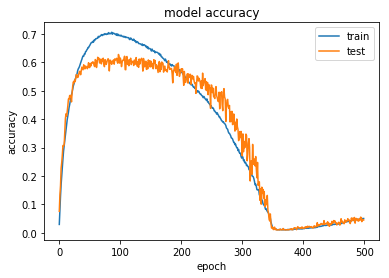

In [50]:
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
#
fig.savefig('accuracy.png')

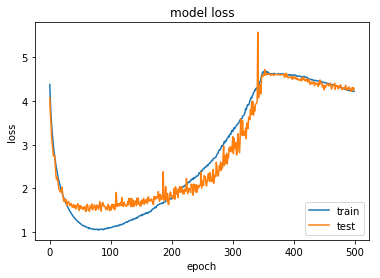

In [51]:
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
#
fig.savefig('loss.png')